In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("../Data/airline_passengers.csv", index_col="Month", parse_dates=True)

df["LogPassengers"] = np.log(df["Passengers"])

In [3]:
Ntest = 12
train = df.iloc[:-Ntest]
test  = df.iloc[-Ntest:]

In [4]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df["LogPassengers"].to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
    X.append(series[t:t+T])
    Y.append(series[t+T])

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (134, 10) Y.shape (134,)


In [5]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest,  Ytest  = X[-Ntest:], Y[-Ntest:]

In [6]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9599443783339898

In [7]:
lr.score(Xtest, Ytest)

0.6910953044565606

In [10]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx  = ~train_idx

train_idx[:T] = False  # first T values are not predictable

In [11]:
# 1-step forecast
df.loc[train_idx, "LR_1step_train"] = lr.predict(Xtrain)
df.loc[test_idx, "LR_1step_test"] = lr.predict(Xtest)

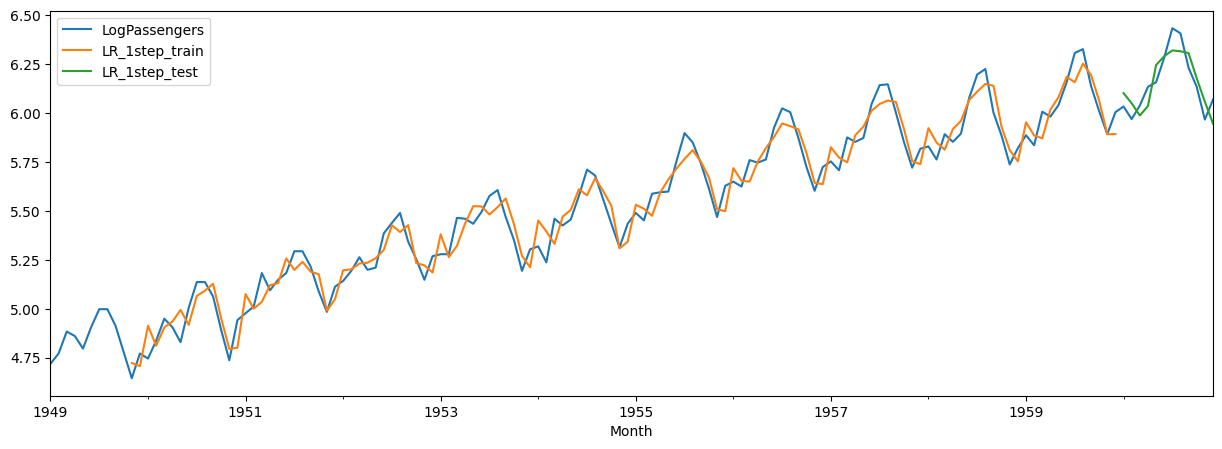

In [12]:

# plot 1-st step forecast
df[["LogPassengers", "LR_1step_train", "LR_1step_test"]].plot(figsize=(15, 5));

In [13]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]

    # update the prediction list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [14]:
# save multi-step forecast to dataframe
df.loc[test_idx, "LR_multistep"] = multistep_predictions

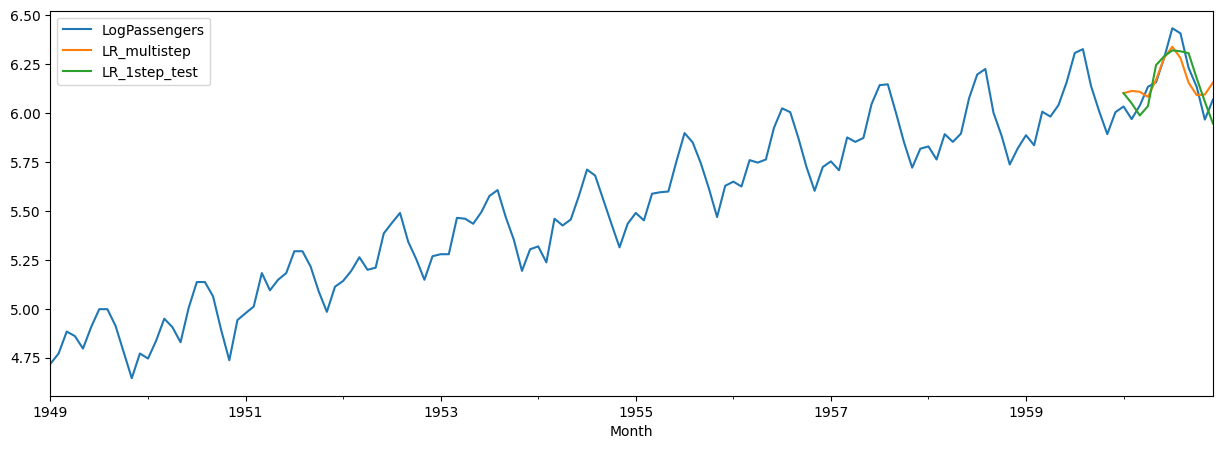

In [15]:
# plot 1-step and multi-step forecast
df[["LogPassengers", "LR_multistep", "LR_1step_test"]].plot(figsize=(15, 5));

In [16]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [19]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [20]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9734607773512526

In [21]:
# SST is zero!
lr.score(Xtest_m, Ytest_m) 

c:\Python\Python38\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [22]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.8018749676715241

In [23]:
# save multi-output forecast to dataframe
df.loc[test_idx, "LR_multioutput"] = lr.predict(Xtest_m).flatten()

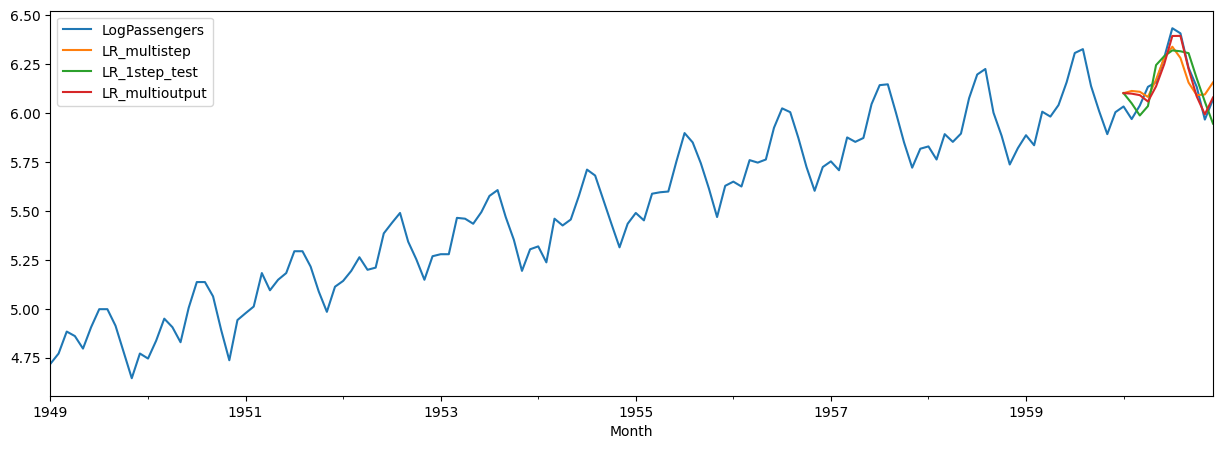

In [24]:
# plot all forecast
cols = ["LogPassengers", "LR_multistep", "LR_1step_test", "LR_multioutput"]
df[cols].plot(figsize=(15, 5));

In [25]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, "LR_multioutput"])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.012229325023475306
multi-output MAPE: 0.007178924475039743


In [28]:
# test other models
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:", model.score(Xtrain, Ytrain))
    # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

    # store 1-step forecast
    df.loc[train_idx, f"{name}_1step_train"] = model.predict(Xtrain)
    df.loc[test_idx, f"{name}_1step_test"] = model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        # update the prediction list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
    
    # store multi-step forecast
    df.loc[test_idx, f"{name}_multistep_test"] = multistep_predictions

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = ["LogPassengers", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test"]
    df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.017529446164230467


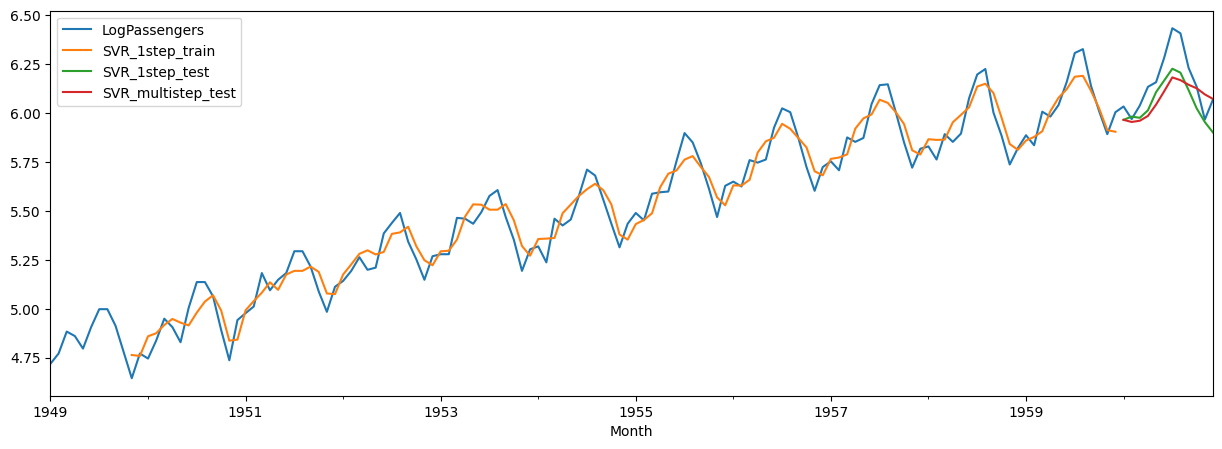

In [29]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.028746453754355836


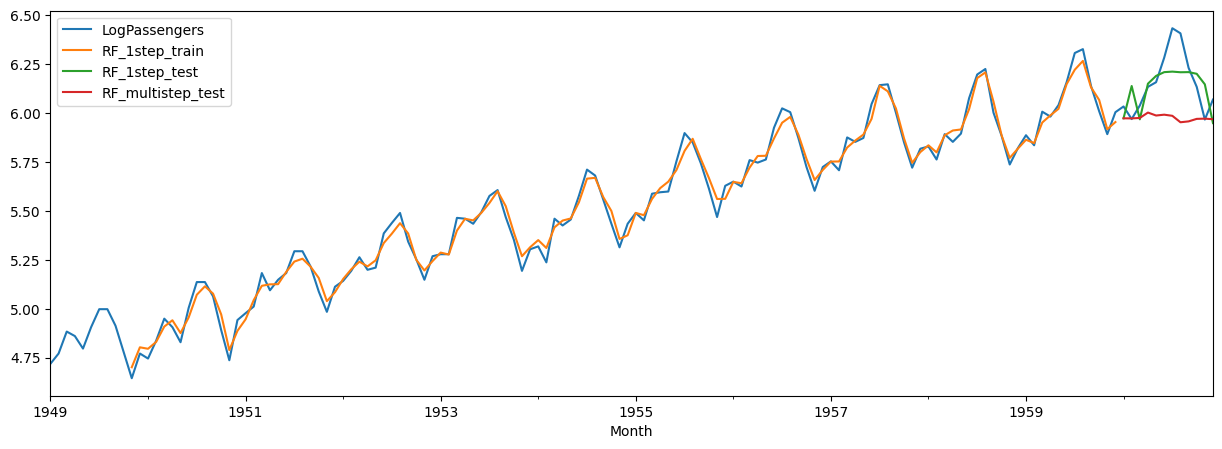

In [30]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [31]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f"{name}_multioutput"] = model.predict(Xtest_m).flatten()

    mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f"{name}_multioutput"])
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = ["LogPassengers", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test", f"{name}_multioutput"]
    df[cols].plot(figsize=(15, 5));

In [32]:
multi_output_forecast(SVR(), "SVR")

# SVM cannot handle multi-output! But: you can still train multiple separate SVRs

ValueError: y should be a 1d array, got an array of shape (122, 12) instead.

Test MAPE (multi-output): 0.017106730969112475


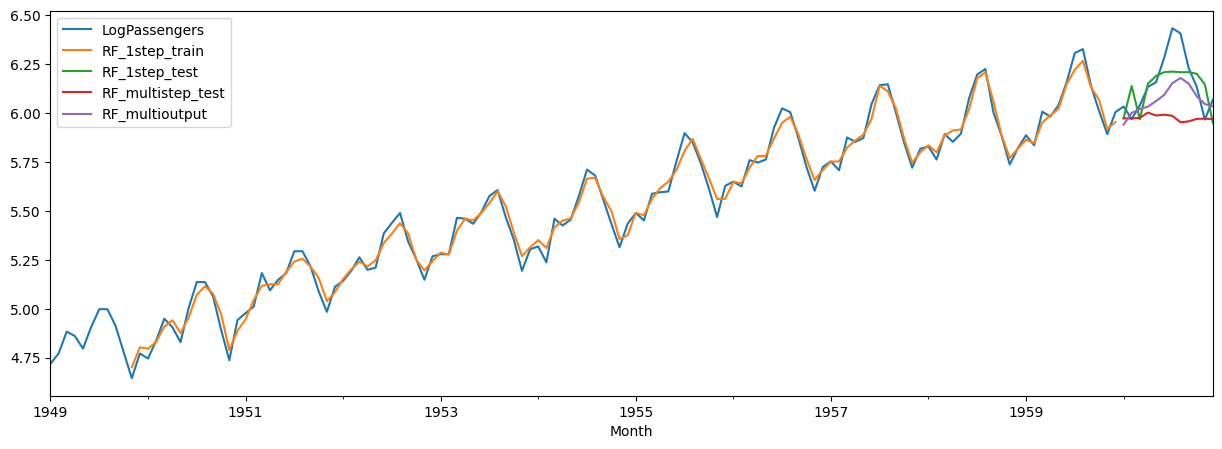

In [33]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)

## With Differencing

In [35]:
df["DiffLogPassengers"] = df["LogPassengers"].diff()

In [36]:
Ntest = 12
train = df.iloc[:-Ntest]
test  = df.iloc[-Ntest:]

In [37]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df["DiffLogPassengers"].to_numpy()[1:] # due to first value is 0, skiping the first row

T = 10
X, Y = [], []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)

    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [38]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [39]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453121

In [40]:
lr.score(Xtest, Ytest)

0.6492870172668168

In [41]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx  = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

In [42]:

# Needed to compute un-differenced predictions
df["ShiftLogPassengers"] = df["LogPassengers"].shift(1)
prev = df["ShiftLogPassengers"]

In [44]:
# Last-known train value
last_train = train.iloc[-1]["LogPassengers"]

In [45]:
# 1-step forecast
df.loc[train_idx, "LR_1step_train"] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, "LR_1step_test"] = prev[test_idx] + lr.predict(Xtest)

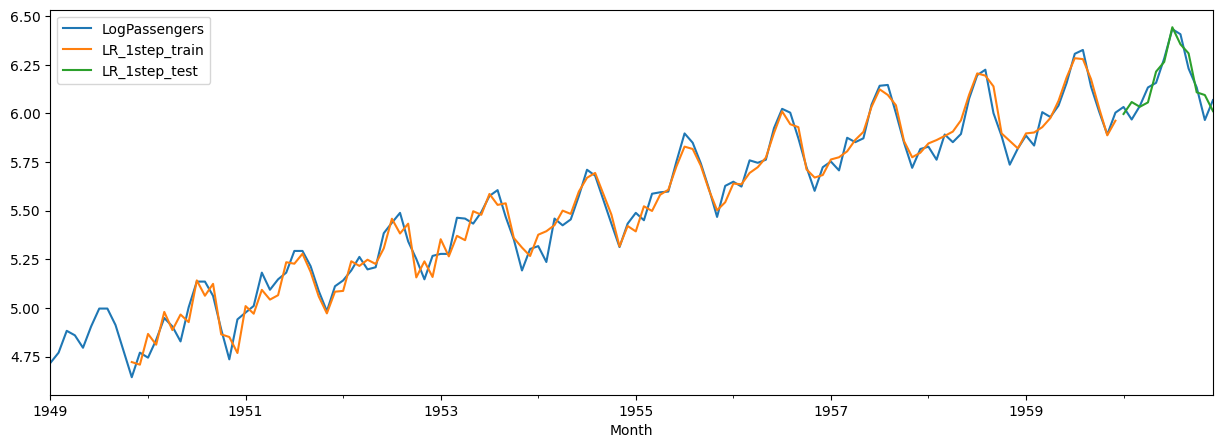

In [47]:
# plot 1-step forecast
df[["LogPassengers", "LR_1step_train", "LR_1step_test"]].plot(figsize=(15, 5));

In [49]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [50]:
# save multi-step forecast to dataframe
df.loc[test_idx, "LR_multistep"] = last_train + np.cumsum(multistep_predictions)

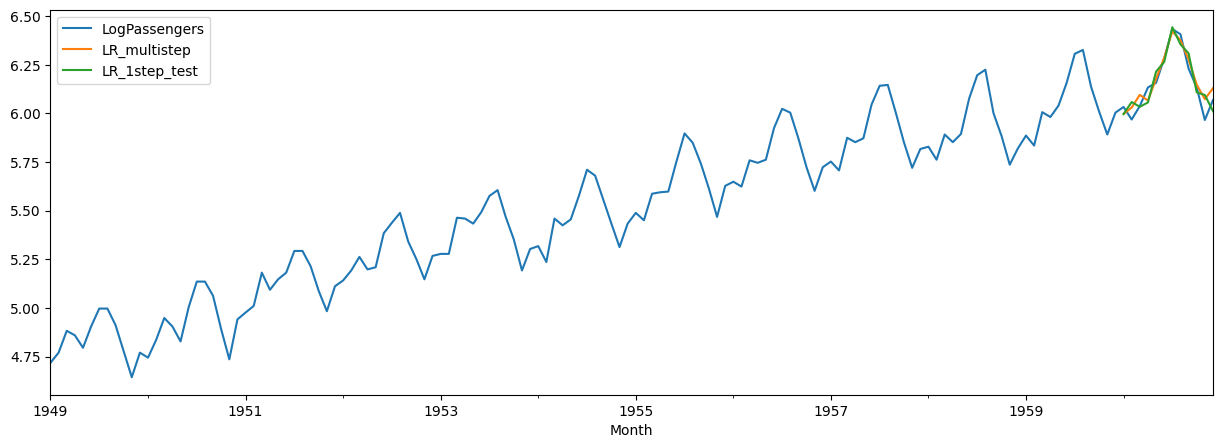

In [51]:
# plot 1-step and multi-step forecast
df[["LogPassengers", "LR_multistep", "LR_1step_test"]].plot(figsize = (15, 5));

In [53]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X, Y = [], []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [54]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [55]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8141637147930583

In [56]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.7690077978619654

In [57]:
# save multi-output forecast to dataframe
df.loc[test_idx, "LR_multioutput"] = last_train + \
    np.cumsum(lr.predict(Xtest_m).flatten())

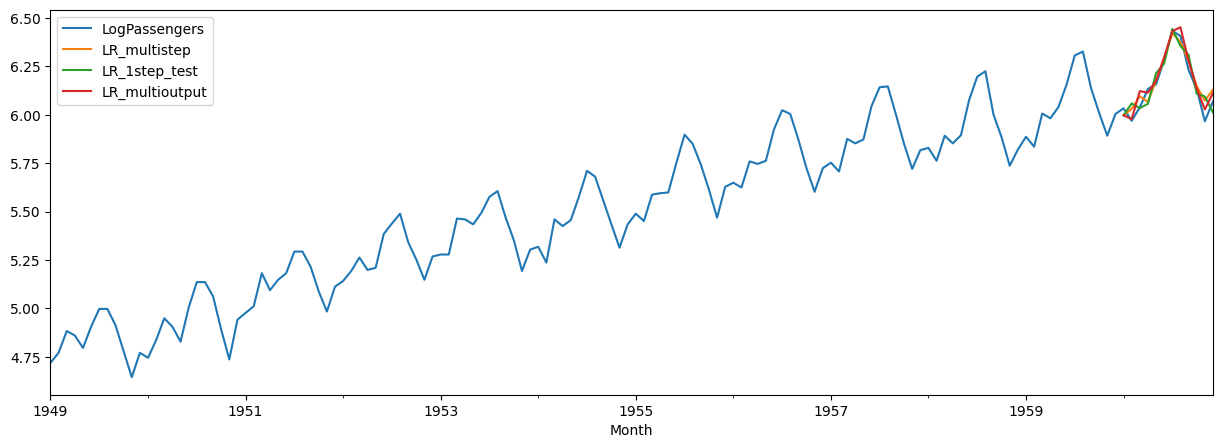

In [58]:
# plot all forecast
cols = ["LogPassengers", "LR_multistep", "LR_1step_test", "LR_multioutput"]
df[cols].plot(figsize=(15, 5));

In [60]:
# MAPE
test_log_pass = df.iloc[-Ntest:]["LogPassengers"]
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, "LR_multistep"])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, "LR_multioutput"])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007109281288502526
multi-output MAPE: 0.005245261617574892


### Test Other Models

In [63]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:", model.score(Xtrain, Ytrain))
    # print("Test r^2 (1-step):", model.score(Xtest, Ytest))

    # score 1-step forecast
    df.loc[train_idx, f"{name}_1step_train"] = prev[train_idx] + model.predict(Xtrain)
    df.loc[test_idx, f"{name}_1step_test"] = prev[test_idx] + model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    df.loc[test_idx, f"{name}_multistep_test"] = last_train + np.cumsum(multistep_predictions)

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f"{name}_multistep_test"])
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = ["LogPassengers", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test"]
    df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


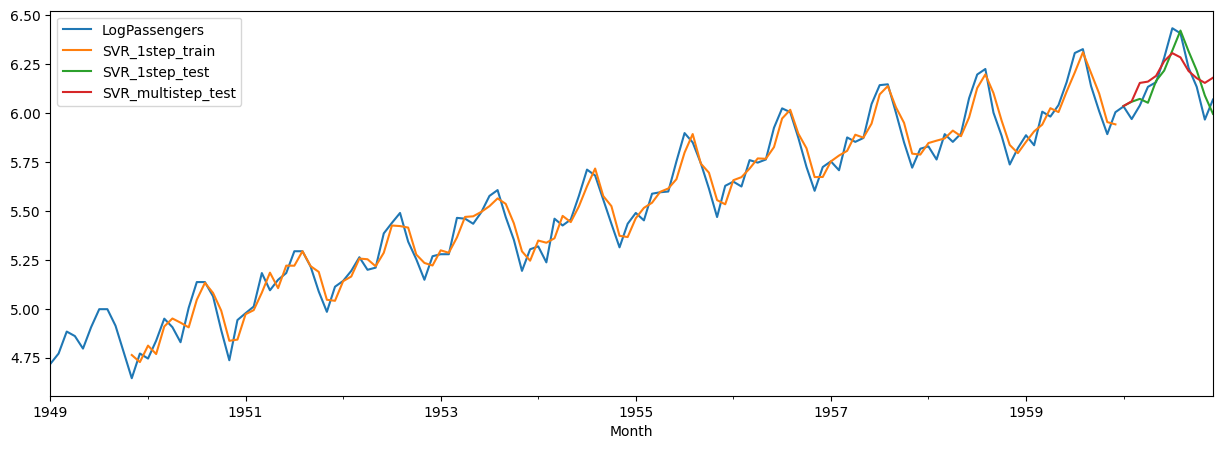

In [64]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.005775940458126371


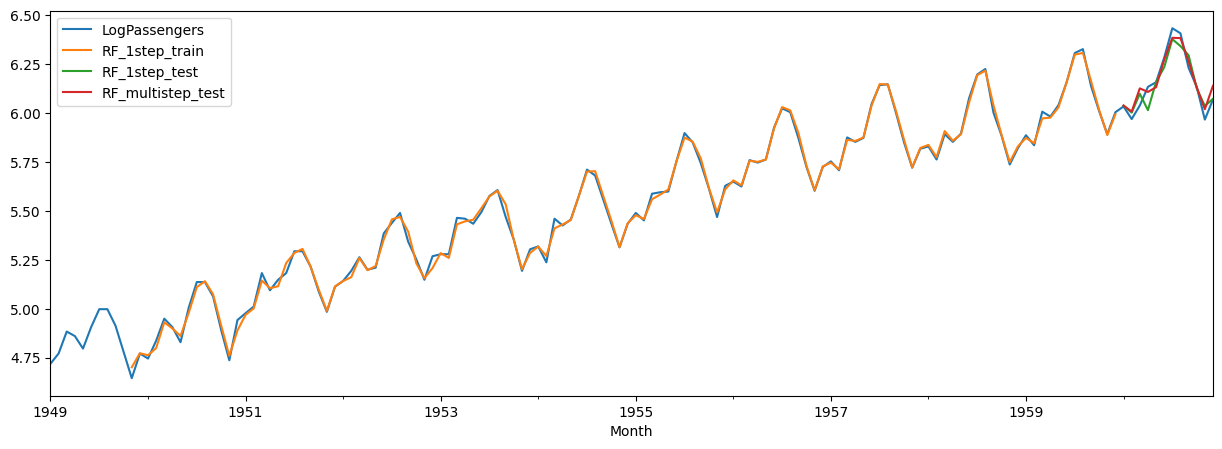

In [65]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [67]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f"{name}_multioutput"] = last_train + np.cumsum(model.predict(Xtest_m).flatten())

    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f"{name}_multioutput"])
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = ["LogPassengers", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test", f"{name}_multioutput"]
    df[cols].plot(figsize=(15,5));

In [68]:
# multi_output_forecast(SVR(), "SVR")  # cann't handle multi-output;

In [69]:
class SVRWrapper:
    def __init__(self, h, **args) -> None:
        self.h = h
        self.models = [SVR(**args) for _ in range(h)]

    def fit(self, X, Y) -> None:
        for k in range(self.h):
            self.models[k].fit(X, Y[:, k])

    def predict(self, X) -> np.ndarray:
        P = [m.predict(X) for m in self.models]
        return np.hstack(P)

Test MAPE (multi-output): 0.010731361803536803


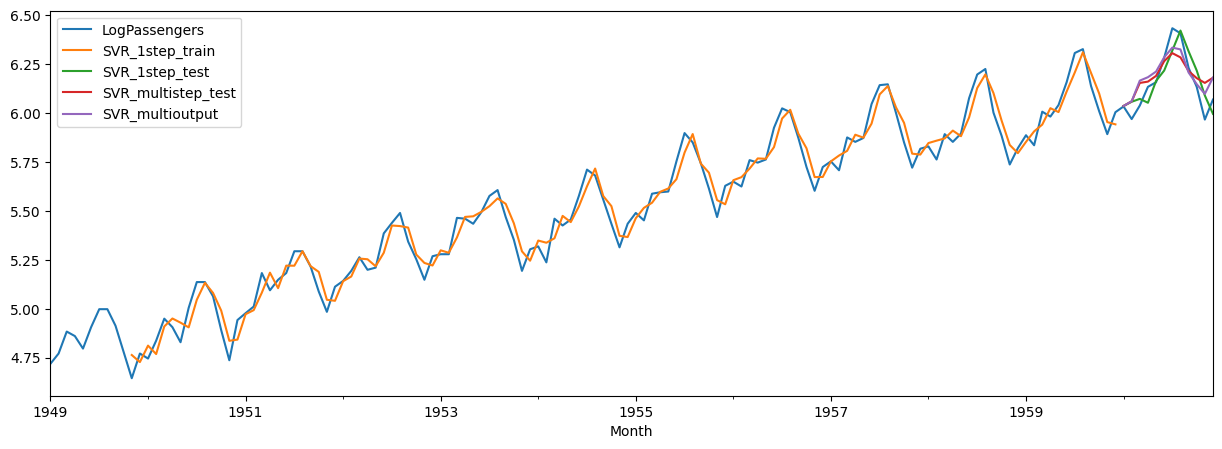

In [70]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.005253744106812144


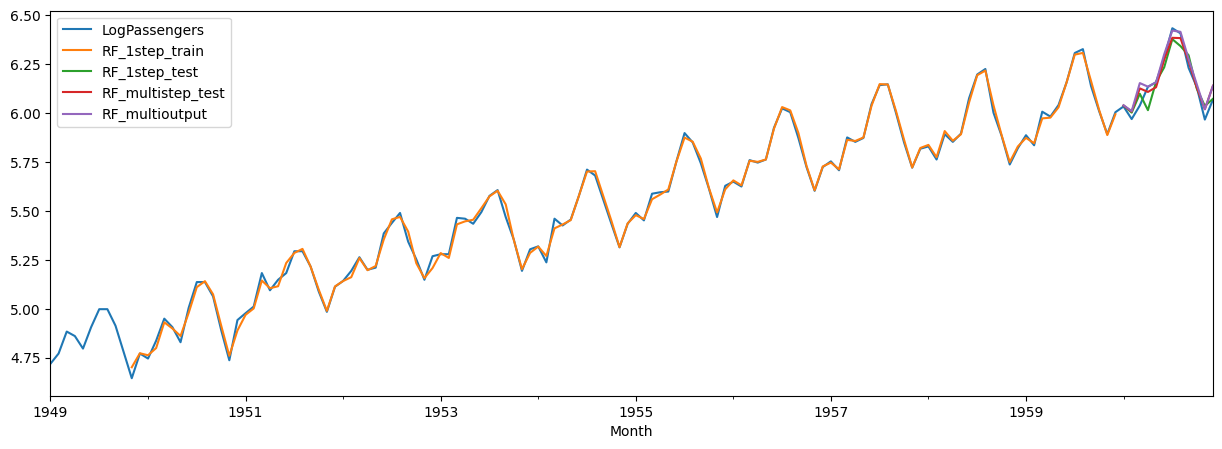

In [71]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: any other SKlearn models you thought of trying?